In [ ]:
!pip install kaggle
!pip install scikit-learn --upgrade
import glob
import zipfile
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
 
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download -d iabhishekofficial/mobile-price-classification
 
 
 
file = glob.glob('*.zip')[0]
with zipfile.ZipFile(file, 'r') as zip_ref:
  zip_ref.extractall('files')

     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Saving kaggle.json to kaggle.json
  0% 0.00/70.6k [00:00<?, ?B/s]
100% 70.6k/70.6k [00:00<00:00, 27.1MB/s]


In [ ]:
import scipy
import warnings
import itertools
import numpy as np
import scipy.stats
import scipy.linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import *
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import *
sns.set()
warnings.filterwarnings('ignore')

In [ ]:
from scipy.special import expit
import scipy.optimize as optimize
from sklearn.metrics import accuracy_score


class SimpleLogisticRegression:
  def __init__(self,C=1,fit_intercept=True):
    self.C = C
    self.fit_intercept = fit_intercept
  
  def _log_logistic(self,X):
      """
      http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/
      """

      X = np.atleast_2d(X)
      n_samples, n_features = X.shape
      
      out = np.empty_like(X)

      for i in range(n_samples):
          for j in range(n_features):            
              x = X[i, j]
              if x > 0:
                  out[i, j] = -np.log(1. + np.exp(-x))
              else:
                  out[i, j] = x - np.log(1. + np.exp(x))
      return out    


  def _logistic_loss_and_grad(self,w, X, y, C):
      n_samples, n_features = X.shape
      grad = np.empty_like(w)

      c = 0.
      if w.size == X.shape[1] + 1:
          c = w[-1]
          w = w[:-1]

      z = np.dot(X, w) + c
      yz = y * z
    
      alpha = 1. / C
      out = -np.sum(self._log_logistic(yz)) + .5 * alpha * np.dot(w, w)

      z = expit(yz)
      z0 = (z - 1) * y

      grad[:n_features] = np.dot(X.T, z0) + alpha * w

      if grad.shape[0] > n_features:
          grad[-1] = z0.sum()
      return out, grad

  def fit(self, X, y):
    if set(np.unique(y)) != {0,1}:
      raise ValueError('vector y values should be 0 or 1')
    yhat = 2*y-1
    w0 = np.zeros(X.shape[1] + int(self.fit_intercept))

    opt_res = optimize.minimize(
      self._logistic_loss_and_grad, w0, method="L-BFGS-B", jac=True,
      args=(X,  yhat,  self.C),
    )
    self.coef_ = opt_res.x
    if self.fit_intercept:
      self.intercept_ = self.coef_[-1]
      self.coef_ = self.coef_[:-1]
    else:
      self.intercept_ = np.zeros(n_classes)
    return self
  def decision_function(self, X):
    n_features = self.coef_.shape[0]
    scores = np.dot(X, self.coef_.T) + self.intercept_
    return scores.ravel()
  def predict(self, X):        
        scores = self.decision_function(X)
        if len(scores.shape) == 1:
            indices = (scores > 0).astype(int)
        return indices
  def score(self,X,y):
    p = self.predict(X)
    return accuracy_score(y,p)


# from sklearn.datasets import load_breast_cancer
# X,y = load_breast_cancer(return_X_y=True)
# X.shape, y.shape
# X = MinMaxScaler().fit_transform(X)

# sclf = SimpleLogisticRegression()
# sclf.fit(X,y)
# sclf.score(X,y)


In [ ]:
def onehot_encode(df, column):    
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column, dtype=bool)
    df = pd.concat([dummies, df], axis=1)
    df = df.drop([column], axis=1)   
    return df 
  
def network(df):
  df['network'] = None
  df.loc[(df['three_g']==0) & (df['four_g']==0),'network'] = 0
  df.loc[(df['three_g']==1) & (df['four_g']==0),'network'] = 1
  df.loc[(df['three_g']==1) & (df['four_g']==1),'network'] = 2
  df.drop(['three_g','four_g'],axis=1, inplace=True)

def preprocess(df):
  if 'id' in list(df):
    df.drop('id', inplace=True,axis=1)
  df = df[df.px_height>0]
  df = df[df.px_width>0]
  # df = df[df.sc_h>0]
  # df = df[df.sc_w>0]
  # df.drop(['m_dep','mobile_wt'], inplace=True,axis=1)
  
  network(df)
  # df['total_cpu'] = df['clock_speed'] * df['n_cores']
  # df['total_cpu'] = pd.cut(df['total_cpu'], 3, labels=False)
  df['lcd'] = (np.sqrt(df['sc_h']**2+df['sc_w']**2)*.3937).round(2)
  df['ppi'] = (np.sqrt(df['px_height']**2+df['px_width']**2) / df['lcd']).round()
  df['aspect_ratio'] = (df['px_width']/df['px_height']).round(2)
  
  # df['n_cam'] = None
  # df.loc[(df['fc']==0) & (df['pc']==0),'n_cam'] = 0
  # df.loc[(df['fc']>0) & (df['pc']==0),'n_cam'] = 1
  # df.loc[(df['fc']==0) & (df['pc']>0),'n_cam'] = 1
  # df.loc[(df['fc']>0) & (df['pc']>0),'n_cam'] = 2
  
  # df['cpu'] = pd.cut(df['clock_speed'], 5, labels=False)
  # df.drop('clock_speed',axis=1, inplace=True)
  
  df['battery'] = pd.cut(df['battery_power'], 5, labels=False)
  # df.drop('battery_power',axis=1, inplace=True)
  

  # df['mem'] = pd.cut(df['ram'], 10, labels=False)
  # df.drop('ram',axis=1, inplace=True)

  # for col in ['blue','dual_sim','touch_screen','wifi']:
  #   df = onehot_encode(df, col)
  
  # df['battery_power'] = df['battery_power'].round(-1)
  # df['int_memory'] = df['int_memory'].round(-1)
  
  cols = list(df)
  if 'price_range' in cols:
    cols.remove('price_range')
    df = df[cols + ['price_range']]
  return df

In [ ]:
train = pd.read_csv('files/train.csv')
test = pd.read_csv('files/test.csv')

train = preprocess(train)
test = preprocess(test)

y = train.iloc[:,-1].to_numpy()
X = train.iloc[:,:-1].to_numpy()

print(X.shape,y.shape)

kf = StratifiedKFold(n_splits=10)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    clf = make_pipeline(StandardScaler(),PCA(22), StandardScaler(),
                      LogisticRegression(C=50, class_weight='balanced'))
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    clf.fit(Xtrain,ytrain)

    trainscore = clf.score(Xtrain,ytrain)
    testscore = clf.score(Xtest,ytest)
    ypred = clf.predict(Xtest)
    precision = precision_score(ytest,ypred,average='macro')
    recall = recall_score(ytest,ypred,average='macro')
    f1 = f1_score(ytest,ypred,average='macro')
    print(i,'th fold. trainscore, testscore, precision, recall, f1 = ', *np.array([trainscore, testscore, precision, recall, f1]).round(2))

    scores.append(np.array([trainscore, testscore, precision, recall, f1]))
pd.DataFrame(np.array(scores)).describe()

(1998, 23) (1998,)
0 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.98 0.98 0.98 0.98
1 th fold. trainscore, testscore, precision, recall, f1 =  0.98 0.98 0.99 0.98 0.98
2 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.96 0.97 0.96 0.96
3 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.98 0.98 0.98 0.97
4 th fold. trainscore, testscore, precision, recall, f1 =  0.98 0.98 0.99 0.98 0.98
5 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.96 0.96 0.96 0.96
6 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.98 0.99 0.98 0.99
7 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.98 0.99 0.98 0.98
8 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.98 0.99 0.98 0.98
9 th fold. trainscore, testscore, precision, recall, f1 =  0.99 0.97 0.97 0.97 0.97


,0,1,2,3,4
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.986987,0.977477,0.977824,0.977469,0.977464
std,0.001875,0.009508,0.009429,0.009493,0.009477
min,0.984983,0.960000,0.960769,0.960000,0.960192
25%,0.985685,0.971137,0.971303,0.971173,0.971005
50%,0.986656,0.982462,0.982739,0.982398,0.982443
75%,0.988042,0.985000,0.985261,0.985000,0.984970
max,0.991101,0.985000,0.985483,0.985000,0.985049


In [ ]:
yprob = clf.predict_proba(Xtest)
PRED = []
for row in yprob:
  indx = np.argmax(row)
  if row[indx] >= .65:
    PRED.append(indx)
  else:
    PRED.append(-1)
PRED = np.array(PRED)
indx = PRED>=0

tmpy = ytest[indx]
tmpX = Xtest[indx,:]
tmppred = PRED[indx]
print(PRED[PRED==-1].shape)

indx = tmppred != tmpy
df = pd.DataFrame(tmpX[indx],columns=list(test))
df['exact'] = tmpy[indx]
df['predict'] = tmppred[indx]
print(df.shape)
df.head()

(8,)
(3, 25)


,battery_power,blue,clock_speed,dual_sim,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,touch_screen,wifi,network,lcd,ppi,aspect_ratio,battery,exact,predict
0,1748,1,0.5,1,11,53,0.5,114,4,20,718,1109,2633,16,0,9,0,0,2,6.3,210,1.54,4,2,3
1,1802,1,1.2,1,8,27,0.5,116,5,16,453,963,1885,10,9,7,1,0,1,5.3,201,2.13,4,2,1
2,689,0,1.4,0,2,45,0.5,103,5,11,256,823,3585,10,1,10,0,0,1,3.96,218,3.21,0,3,2


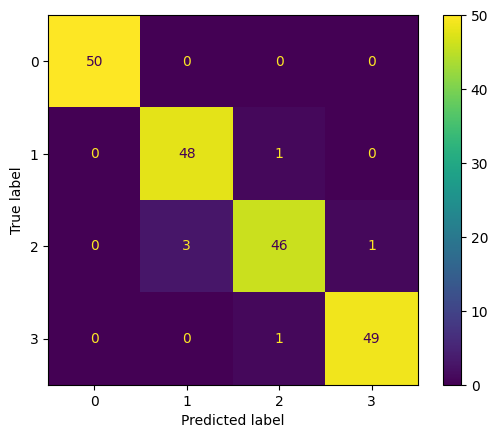

In [ ]:
sns.reset_defaults()
plot_confusion_matrix(clf, Xtest, ytest,values_format='d') 
plt.show()

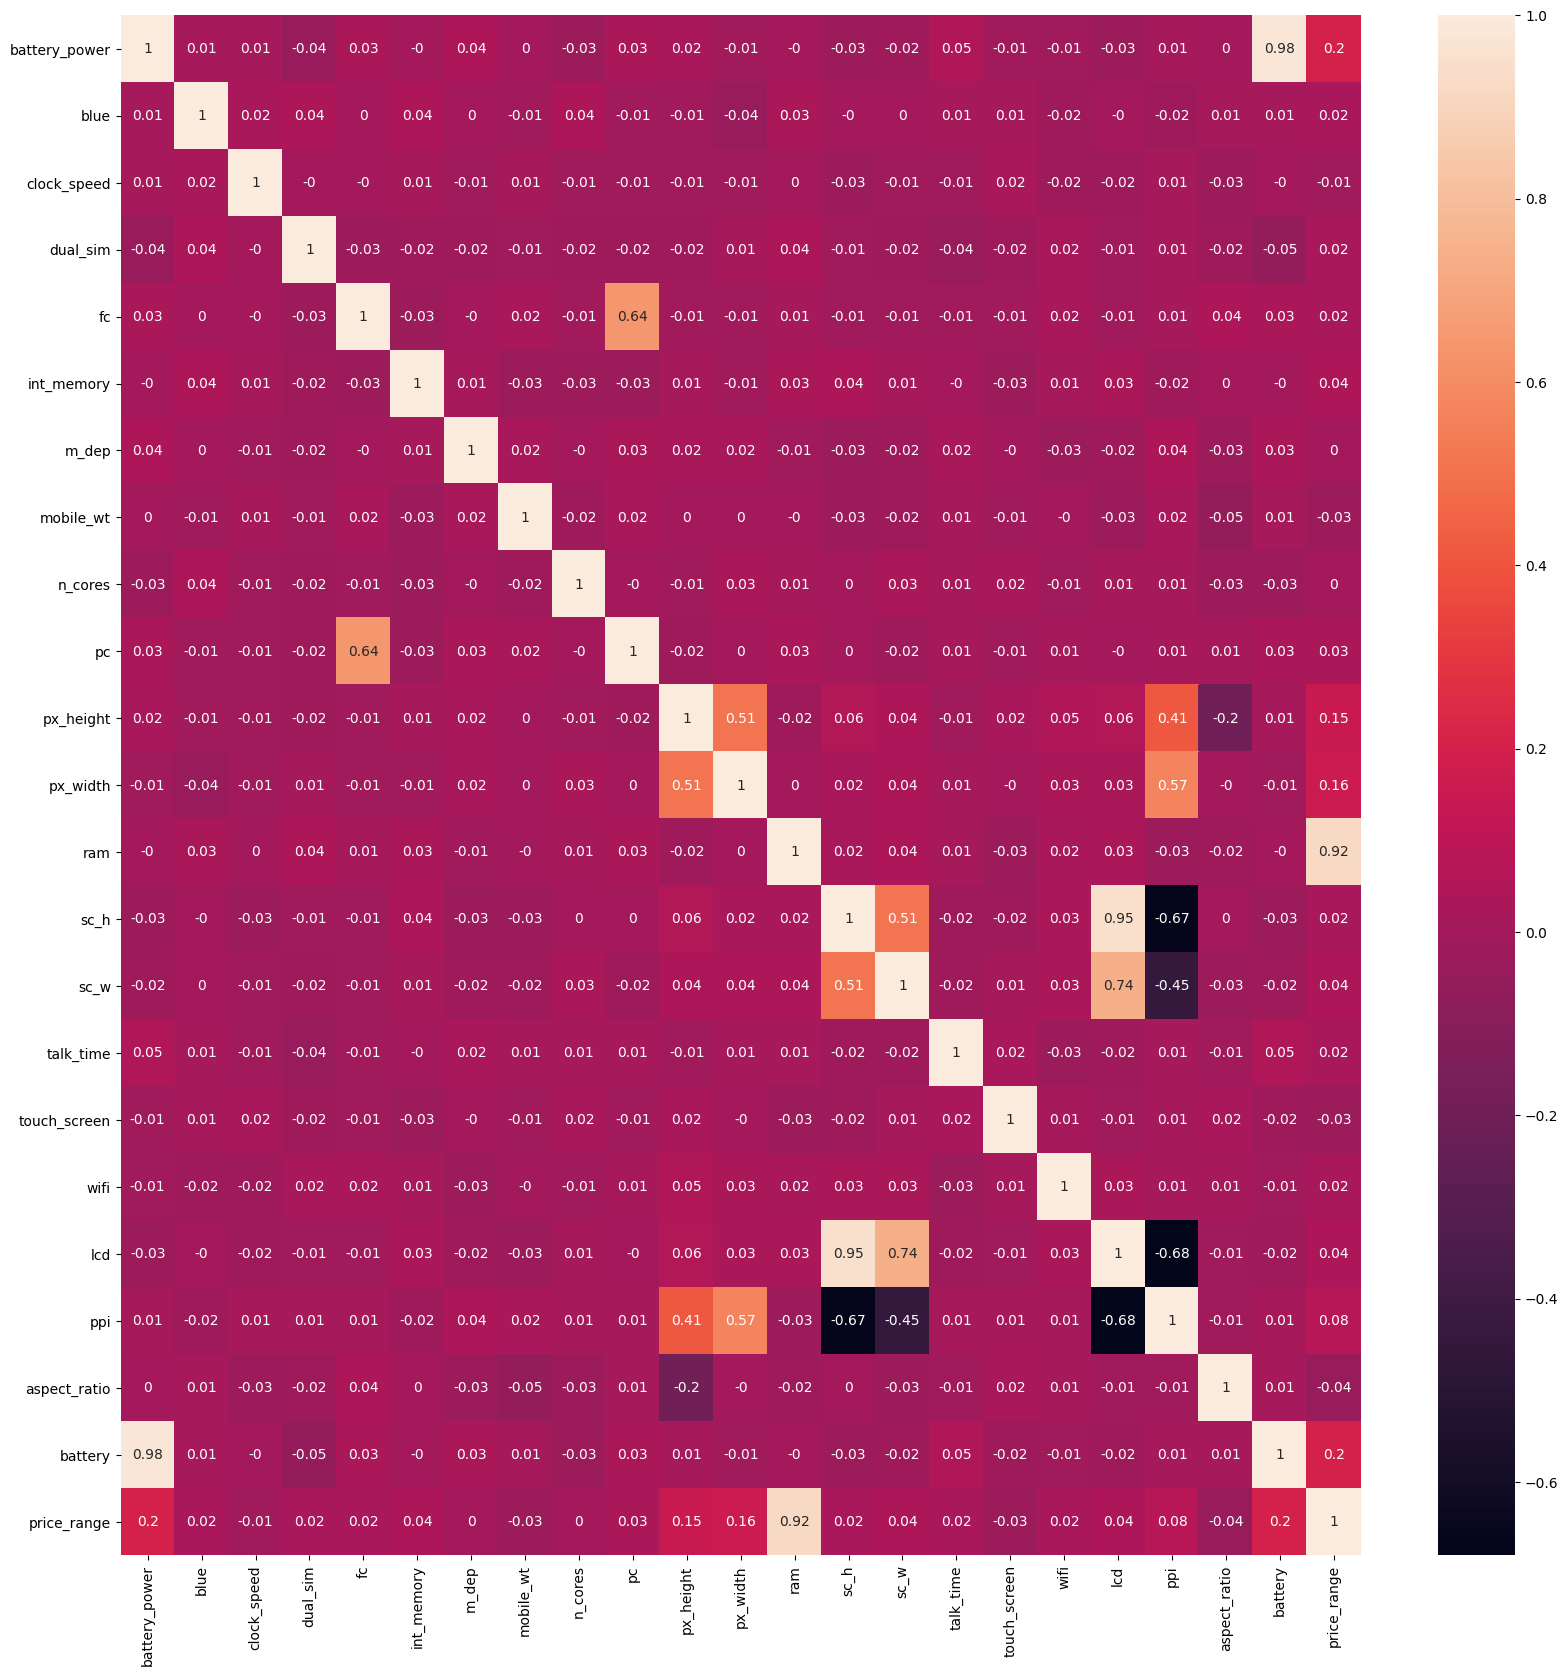

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
corr_matrix = train.corr().round(2)
sns.heatmap(corr_matrix, annot=True,ax=ax)
plt.show()

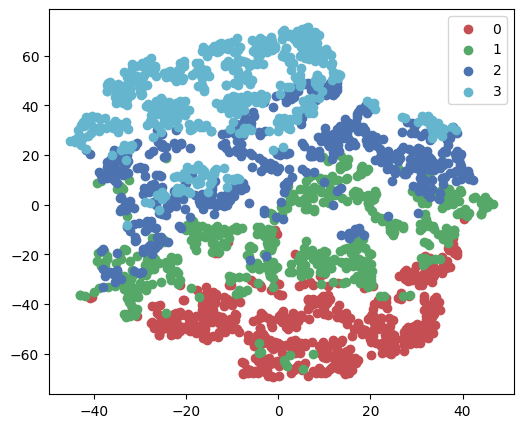

In [ ]:
from sklearn.manifold import TSNE
X_2d = TSNE(n_components=2).fit_transform(X)

target_ids = range(4)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ['0','1','2','3']):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

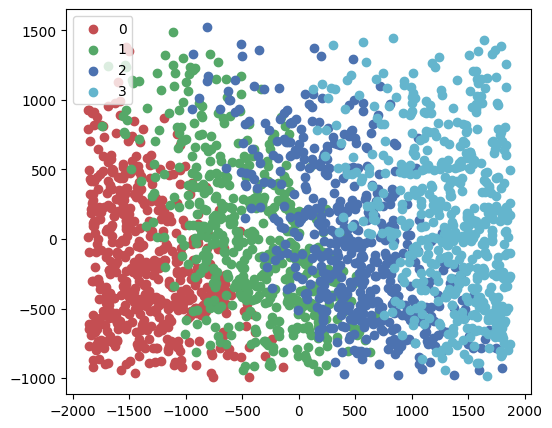

In [ ]:
from sklearn.manifold import TSNE
X_2d = PCA(n_components=2).fit_transform(X)

target_ids = range(4)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ['0','1','2','3']):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

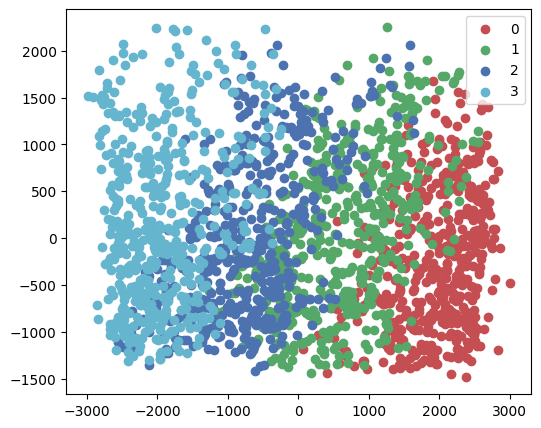

In [ ]:
from sklearn.manifold import TSNE
X_2d = Isomap(n_components=2).fit_transform(X)

target_ids = range(4)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ['0','1','2','3']):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

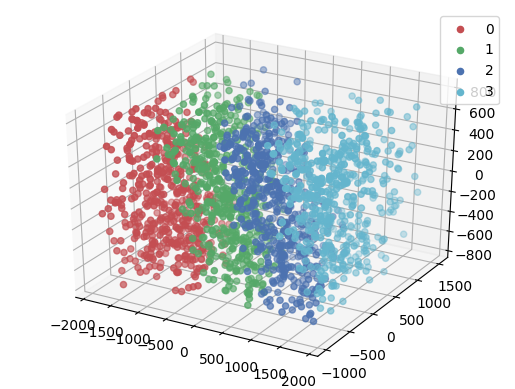

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X_3d = PCA(n_components=3).fit_transform(X)

target_ids = range(4)

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ['0','1','2','3']):
    ax.scatter(X_3d[y == i, 0], X_3d[y == i, 1],X_3d[y == i, 2], c=c, label=label)
plt.legend()
plt.show()

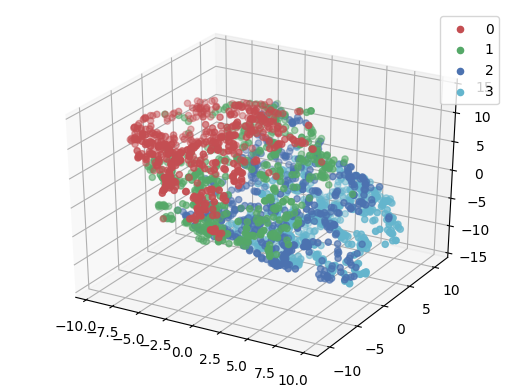

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X_3d = TSNE(n_components=3).fit_transform(X)

target_ids = range(4)

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, ['0','1','2','3']):
    ax.scatter(X_3d[y == i, 0], X_3d[y == i, 1],X_3d[y == i, 2], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
N = ytrain.shape[0]
for i in np.unique(ytrain):
  k = ytrain[ytrain==i].shape[0]
  print(i, k/N)

0 0.2501389660922735
1 0.2501389660922735
2 0.2501389660922735
3 0.24958310172317955


In [ ]:
y2 = np.where(y>0,1,y)

kf = StratifiedKFold(n_splits=10)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X, y2)):
    clf = make_pipeline(StandardScaler(),
                      LogisticRegression(C=1000, class_weight='balanced'))
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y2[train_index], y2[test_index]
    clf.fit(Xtrain,ytrain)

    trainscore = clf.score(Xtrain,ytrain)
    testscore = clf.score(Xtest,ytest)
    ypred = clf.predict(Xtest)
    precision = precision_score(ytest,ypred,average='macro')
    recall = recall_score(ytest,ypred,average='macro')
    f1 = f1_score(ytest,ypred,average='macro')
    print(i,'th fold. trainscore, testscore, precision, recall, f1 = ', *np.array([trainscore, testscore, precision, recall, f1]).round(2))

    scores.append(testscore)
pd.DataFrame(np.array(scores)).describe()

0 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 0.99 0.99
1 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0
2 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.98 0.98 0.98 0.98
3 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.98 0.99 0.99
4 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 0.99 1.0 0.99
5 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 0.99 0.99
6 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0
7 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.98 0.99 0.99
8 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.99 1.0 0.99
9 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0


,0
count,10.000000
mean,0.994497
std,0.004972
min,0.985000
25%,0.991244
50%,0.995000
75%,0.998750
max,1.000000


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
# X, y = load_iris(return_X_y=True)
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=15,direction='forward',scoring='roc_auc')
sfs.fit(X, y)

included = np.array(list(test))[sfs.get_support()]
Xnew = sfs.transform(X)

In [ ]:
kf = StratifiedKFold(n_splits=10)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(Xnew, y2)):
    clf = make_pipeline(StandardScaler(),
                      LogisticRegression(C=1000, class_weight='balanced'))
    Xtrain, Xtest = Xnew[train_index], Xnew[test_index]
    ytrain, ytest = y2[train_index], y2[test_index]
    clf.fit(Xtrain,ytrain)

    trainscore = clf.score(Xtrain,ytrain)
    testscore = clf.score(Xtest,ytest)
    ypred = clf.predict(Xtest)
    precision = precision_score(ytest,ypred,average='macro')
    recall = recall_score(ytest,ypred,average='macro')
    f1 = f1_score(ytest,ypred,average='macro')
    print(i,'th fold. trainscore, testscore, precision, recall, f1 = ', *np.array([trainscore, testscore, precision, recall, f1]).round(2))

    scores.append(testscore)
pd.DataFrame(np.array(scores)).describe()

0 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 0.99 1.0 0.99
1 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0
2 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.99 0.99 0.99
3 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.98 0.99 0.99
4 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0
5 th fold. trainscore, testscore, precision, recall, f1 =  1.0 1.0 1.0 1.0 1.0
6 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.99 0.99 0.99
7 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.98 0.99 0.99
8 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.98 0.98 0.98 0.98
9 th fold. trainscore, testscore, precision, recall, f1 =  1.0 0.99 0.99 1.0 0.99


,0
count,10.000000
mean,0.993490
std,0.005309
min,0.984925
25%,0.990000
50%,0.992487
75%,0.998750
max,1.000000
